# Dynamic Webscraping with Selenium

In the last workshop, we saw how to use `BeautifulSoup` to scrape data from a website and read that data into a powerful data structure called a `pandas` `DataFrame`. In this notebook, we'll do something very similar again. We'll be taking a website url, passing it through 3rd party software and extracting useful information that we can use to populate a DataFrame. This time, however, we will be scraping a *dynamic* website, that is a website whose HTML code is generated by an application.

## Our Task in this notebook
We are going to scrape the headlines from today's issue of the [New York Times](https://www.nytimes.com/). Then, we'll put this data in a `DataFrame` and save it locally as a csv for later use.

A note on copyright: all Tufts logins come with the New York Times, so be sure to log into your Tufts account before you continue. Please find instructions on doing so [here](https://researchguides.library.tufts.edu/nytimes).

## Goals:
* Understand what a dynamic website is and how it is different from a static website
* Install `Selenium` along with it's associated dependencies
* Navigate the content of the site both in `Selenium` and `BeautifulSoup`
* Get more experience with generating DataFrames

## What is a dynamic website
Let's delve a bit deeper into what a dynamic website is and why we can't just use `BeautifulSoup` to parse it as we can with static websites. While a static webpage would require a manual update before content on the site can change, a dynamic website takes advantage of client and server-side scripting to be more adaptable to a user's needs.
* Client-side scripting: code that is executed by the user's browser, generally using JavaScript. This scripting renders changes to the site when the user interacts with it. This can be anything from selecting a choice in a drop down menu to full fledged games like Wordle. This type of scripting is also common in many static sites.
* Server-side scripting: code that is executed by the server before sending content to the user's browser. This code can be written in a wide varity of languages like Ruby (`RubyOnRails`), JavaScript (`VueJS`, `NodeJS`) and Python (`Django`, `Flask`). This code generally gets inputs from querying a database associated with the site and outputs HTML code from a template. This way, programmers can update elements in their sites without having to rewrite large sections of it. But, it also means that the HTML is not yet generated when we do a get request.

Let's look at what this means for us in Python code below.

In [1]:
## what we did in part i of the art of webscraping. if this isn't making any sense, check out [LINK TO PART I]
from bs4 import BeautifulSoup
import requests

soup = BeautifulSoup(requests.get('https://www.nytimes.com/').text)

In [2]:
soup

<!DOCTYPE html>

<html class="nytapp-vi-homepage" lang="en" xmlns:og="http://opengraphprotocol.org/schema/">
<head>
<meta charset="utf-8"/>
<title data-rh="true">The New York Times - Breaking News, US News, World News and Videos</title>
<meta content="Live news, investigations, opinion, photos and video by the journalists of The New York Times from more than 150 countries around the world. Subscribe for coverage of U.S. and international news, politics, business, technology, science, health, arts, sports and more." data-rh="true" name="description"/><meta content="https://www.nytimes.com" data-rh="true" property="og:url"/><meta content="website" data-rh="true" property="og:type"/><meta content="The New York Times - Breaking News, US News, World News and Videos" data-rh="true" property="og:title"/><meta content="Live news, investigations, opinion, photos and video by the journalists of The New York Times from more than 150 countries around the world. Subscribe for coverage of U.S. and i

What is this mess? There is clearly useful information, like headlines, here, but it's really hard to figure out how to scrape it. There doesn't seem to be an inherent structure of the site that we can take advantage of, as we did in the last notebook. Instead, we are going to use `Selenium` to render this site in a browser, so we can then use access the HTML output without dealing with the back-end of the site, which we don't have access to.

## `Selenium`: what is it and how does it works

`Selenium` is a software package that automates an instance of a particular browser in the runtime of many programming languages, including Ruby, JavaScript and of course Python.

In order to use Selenium in any environment, one must first download the driver to a web browser (we'll be using Chrome) and then also install the software package itself (we'll be using pip).

I chose to put this notebook lesson on Colab because the Linux environment makes it very easy to download and install the dependencies needed to use `Selenium`, but if you prefer to use this notebook locally, either run it in a WSL terminal (CHECK ON THIS) or follow the official [documentation](https://selenium-python.readthedocs.io/).

In [3]:
## installing all of the dependencies as well as the selenium package
%%shell

# Add debian buster
cat > /etc/apt/sources.list.d/debian.list <<'EOF'
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster.gpg] http://deb.debian.org/debian buster main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-buster-updates.gpg] http://deb.debian.org/debian buster-updates main
deb [arch=amd64 signed-by=/usr/share/keyrings/debian-security-buster.gpg] http://deb.debian.org/debian-security buster/updates main
EOF

# Add keys
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys DCC9EFBF77E11517
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 648ACFD622F3D138
apt-key adv --keyserver keyserver.ubuntu.com --recv-keys 112695A0E562B32A

apt-key export 77E11517 | gpg --dearmour -o /usr/share/keyrings/debian-buster.gpg
apt-key export 22F3D138 | gpg --dearmour -o /usr/share/keyrings/debian-buster-updates.gpg
apt-key export E562B32A | gpg --dearmour -o /usr/share/keyrings/debian-security-buster.gpg

# Prefer debian repo for chromium* packages only
# Note the double-blank lines between entries
cat > /etc/apt/preferences.d/chromium.pref << 'EOF'
Package: *
Pin: release a=eoan
Pin-Priority: 500


Package: *
Pin: origin "deb.debian.org"
Pin-Priority: 300


Package: chromium*
Pin: origin "deb.debian.org"
Pin-Priority: 700
EOF

# Install chromium and chromium-driver
apt-get update
apt-get install chromium chromium-driver

# Install selenium
pip install selenium

SyntaxError: invalid decimal literal (1380532272.py, line 13)

In [ ]:
from selenium import webdriver # the main entry point for the selenium API, the webdriver
chrome_options = webdriver.ChromeOptions() # some useful features for the chrome driver
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')
wd = webdriver.Chrome(options=chrome_options) # final webdriver object

SessionNotCreatedException: ignored

In [ ]:
wd

Just like when we used `requests`, we can use the get method to load the site into our runtime

In [ ]:
wd.get('https://www.nytimes.com/')

If we want to get the headlines from each article, we need to select the `section` tags. In `BeautifulSoup`, we could use something like `soup.find_all('section')`, but the syntax is slightly different in `Selenium`.

Check out the documentation [here](https://selenium-python.readthedocs.io/locating-elements.html).

In [ ]:
[i.get_attribute('outerHTML') for i in wd.find_elements(By.XPATH, './/section//h3')]

In [ ]:
## first, this By class allows us to select many options to search by
## here, we'll query by HTML tag
from selenium.webdriver.common.by import By

sections = wd.find_elements(By.TAG_NAME, 'section') # NOTE: I used find_elements with an 's', if you were to use find_element, it would only return the first element that meets the condiction, which can be useful

In [ ]:
sections[6].find_element(By.TAG_NAME,'h3')#.get_attribute('outerHTML')

In [ ]:
for section in sections:
    if (len(section.text) > 0): # omitting all of the empty titles
        print(type(section), section.text.replace('\n', ''), sep='\t')
    else:
        print(type(section), section.find_element(By.TAG_NAME,'h3'), sep='\t')

This is getting there, but there is still a lot of stuff in here that we don't want. We could just remove the end of the list and hard code and indexing statement like `list_of_tags[:idx_of_last_headline]`, but this is dangerous, as the New York Times changes at least everyday, sometimes multiple times a day, so we will use a more robust method of querying the webpage than just HTML tag.

Instead, we are going to select headlines by how they are styled on the webpage. Below, I have printed out all of the links of the site, which will have all of the headlines we want. Go through this list and determine which class attributes we want for our headlines.

In [ ]:
a_tags = wd.find_elements(By.TAG_NAME, 'a')
for a in a_tags:
  print(a.text, a.get_attribute("class"), sep='\t')

SKIP TO CONTENT	css-kgn7zc
SKIP TO SITE INDEX	css-kgn7zc
SKIP ADVERTISEMENT	css-777zgl
	css-nhjhh0 ell52qj1
	css-ogiugu
	css-ogiugu
	css-ogiugu
	css-ogiugu
	css-ogiugu
	nytcp-opt css-1kj7lfb
	css-1kj7lfb
	css-129gw94
	css-hnzl8o
SUBSCRIBE FOR $1/WEEK	nytcp-opt
	css-1q2j1fr eoab3xr0
	
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-1wjnrbv
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew
	css-13phoew


From this list, I found `css-9mylee` and `css-rgq5s4` as the two main headline classes. Now we can use XPATH filtering to isolate them.

In [ ]:
## here, we are going to use the XPATH attribute of the By class
## XPATH is a common practice for XML parsing that can be extended to HTML using XHTML

## in order to process two XPATH patterns, we can make a list of them and feed them into
## the find_elements method one by one

patterns = [
    "//a[@class='css-9mylee']",
    "//a[@class='css-rgq5s4']"
]

for pattern in patterns:
  hls = wd.find_elements(By.XPATH, pattern)
  for hl in hls:
    if (len(hl.text) > 0):
      print(hl.text)
      print('_____________________') ## print this here so we see where each a tag stops

Ukraine Seeks a Breakthrough in the South but Faces Big Obstacles
The goal of Ukraine’s counteroffensive is to drive a wedge through Russian-occupied territory. But the execution has proved difficult.
See more headlines 9+
_____________________
President Vladimir Putin promised free grain to at least six African countries at a summit, hoping to shore up Russia’s image.
_____________________


But, now there is stuff here, like the author name or how long a read the article is, that isn't the headline and we still haven't been able to scrape the link to the article itself.

Now, we want to look at the raw HTML at these place and try to deal with the problems above with BeautifulSoup parsing.

In [ ]:
for pattern in patterns:
  hls = wd.find_elements(By.XPATH, pattern)
  for hl in hls:
    if (len(hl.text) > 0):
      print(hl.get_attribute('outerHTML')) ## this is the only line different from above
      print('_____________________')

<a class="css-9mylee" href="https://www.nytimes.com/live/2023/07/27/world/russia-ukraine-news" data-uri="nyt://legacycollection/463190d1-6363-5d86-ba23-4d5060307987" aria-hidden="false"><div><div class="css-xdandi"><h3 class="indicate-hover css-vf1hbp">Ukraine Seeks a Breakthrough in the South but Faces Big Obstacles</h3></div><p class="summary-class css-dcsqcp">The goal of Ukraine’s counteroffensive is to drive a wedge through Russian-occupied territory. But the execution has proved difficult.</p></div><p class="css-ikai89">See more headlines <span role="link" aria-label="9 or more more headlines available" class="css-h6rqug">9+</span></p></a>
_____________________
<a class="css-9mylee" href="https://www.nytimes.com/2023/07/27/world/europe/putin-russia-africa-summit.html" data-uri="nyt://article/6458bd89-437b-5db4-bc22-cb1ed0f3b225" aria-hidden="false"><div><div class="css-xdandi"><h3 class="indicate-hover css-1gb49m4">President Vladimir Putin promised free grain to at least six Afric

Because we now have the raw HTML, we can call BeautifulSoup and sort out any issues that way.

We are going to use the `href` value in the a tag to govern what type of headline we are going to look for in each `a` tag.
* First, we don't want any of the games or podcast titles, so we can search the link to see if it has any keywords that would suggest it is one of these. Using the `in` operator and treating the link like any string, we can filter out the results we don't want
* Once we have all of the headlines, we can again search the link to see if it is in the opinion section. If it is, then both the author's name and the article's name will be in a `h3` tag, and we can select which one we want accordingly.

Note that for both of these operations, I needed a familiarity with the webpage beyond just want it looks like in my browser. I needed to experiement with what worked and follow the HTML of the site as closely as I could.

In [ ]:
from bs4 import BeautifulSoup
for pattern in patterns:
  hls = wd.find_elements(By.XPATH, pattern)
  for hl in hls:
    if (len(hl.text) > 0):
      soup = BeautifulSoup(hl.get_attribute('outerHTML'))
      link = soup.find('a')['href']
      if not isinstance(soup.find('h3'), type(None)): ## filtering out any none objects, that is links with no h3 tags
        if ('tips' not in link) and ('puzzles' not in link) and ('crossword' not in link) and ('games' not in link) and ('podcasts' not in link) and ('briefing' not in link):
          if ('opinion' in link):
            headline = soup.find_all('h3')[1].text
            print(link, headline)
          else:
            headline = soup.find('h3').text
            print(link, headline)

https://www.nytimes.com/live/2023/07/27/world/russia-ukraine-news Ukraine Seeks a Breakthrough in the South but Faces Big Obstacles
https://www.nytimes.com/2023/07/27/world/europe/putin-russia-africa-summit.html President Vladimir Putin promised free grain to at least six African countries at a summit, hoping to shore up Russia’s image.


In [ ]:
## now let's move this to a dataframe
import pandas as pd
headline_dict = {}
for pattern in patterns:
  hls = wd.find_elements(By.XPATH, pattern)
  for hl in hls:
    if (len(hl.text) > 0):
      soup = BeautifulSoup(hl.get_attribute('outerHTML'))
      link = soup.find('a')['href']
      if not isinstance(soup.find('h3'), type(None)):
        if ('tips' not in link) and ('puzzles' not in link) and ('crossword' not in link) and ('games' not in link) and ('podcasts' not in link) and ('briefing' not in link) and ('theathletic' not in link):
          if ('opinion' in link):
            headline = soup.find_all('h3')[1].text
            headline_dict[headline] = link
          else:
            headline = soup.find('h3').text
            headline_dict[headline] = link

headline_df = pd.DataFrame.from_dict(headline_dict, orient='index').reset_index().rename(columns={'index':'headline', 0:'link'})

In [ ]:
headline_df

,headline,link
0,World Cup: Croatia vs. Japan,https://www.nytimes.com/live/2022/12/05/sports...
1,Russia-Ukraine War,https://www.nytimes.com/live/2022/12/05/world/...
2,Supreme Court Gay Rights Case,https://www.nytimes.com/live/2022/12/05/us/sup...
3,Supreme Court Hears Case Pitting Gay Rights Ag...,https://www.nytimes.com/live/2022/12/05/us/sup...
4,Blasts Reported at 2 Military Bases Deep Insid...,https://www.nytimes.com/live/2022/12/05/world/...
5,Advice for Europeans: Bundle Up and Get Ready ...,https://www.nytimes.com/2022/12/05/business/eu...
6,War and sanctions are threatening to thrust Ru...,https://www.nytimes.com/2022/12/05/world/europ...
7,DealBook: Energy traders pushed crude prices h...,https://www.nytimes.com/2022/12/05/business/de...
8,Covid Protests in China Raise Hope for Solidar...,https://www.nytimes.com/2022/12/05/world/asia/...
9,"China has stemmed the wave of mass protests, b...",https://www.nytimes.com/2022/12/05/world/asia/...


Now we have a really clean `DataFrame` that we can use to then get the text from each of these articles.

In [ ]:
# let's use our new Selenium skills to pull the dynamically generated text from the article
a_link = headline_df['link'].iloc[9]

# here, I am making a new webdriver object, we don't need to but it can be helpful if you have multiple
article_wd = webdriver.Chrome('chromedriver',options=chrome_options)
article_wd.get(a_link)

In [ ]:
# the paragraphs are predictably held in p tags
for p in article_wd.find_elements(By.TAG_NAME, 'p'):
  print(BeautifulSoup(p.get_attribute('outerHTML')).text)

Advertisement
Supported by
Students, residents, lawyers and workers are still challenging the country’s Covid-19 restrictions, even though the intensity of the political chants has been dialed back.
Send any friend a story
As a subscriber, you have 10 gift articles to give each month. Anyone can read what you share.
By Chang Che, Chris Buckley, Amy Chang Chien and Joy Dong
In central China, students chanted demands for more transparency about Covid rules, while avoiding the bold slogans that riled the Communist Party a week earlier. In Shanghai, residents successfully negotiated with the local authorities to stop a lockdown of their neighborhood. And despite pressure from officials, a team of volunteer lawyers across China, committed to defending the right of citizens to voice their views, fielded anxious calls from protesters.
The recent wave of demonstrations that washed over China was prompted by frustration about pandemic restrictions, but the unrest also sometimes resulted in call

Again, there's some text here that we don't want, mostly at the beginning and a couple throoughout.

In [ ]:
for p in article_wd.find_elements(By.TAG_NAME, 'p'):
  print(p.get_attribute('class'))



css-1n0orw4 e1wiw3jv0
css-6yj280
css-4m7ryc
css-4anu6l e1jsehar1
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0

css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0

css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
vhs-data
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0

css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
vhs-data
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0

css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
vhs-data
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0

css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0
css-at9mc1 evys1bk0

css-i0n974


It seems that the css class `css-at9mc1 evys1bk0` will select all of the text paragraphs, while leaving out the other information we don't want.

In [ ]:
paragraphs = []
for p in article_wd.find_elements(By.TAG_NAME, 'p'):
  if p.get_attribute('class') == 'css-at9mc1 evys1bk0':
    paragraphs.append(BeautifulSoup(p.get_attribute('outerHTML')).text)
paragraphs

['In central China, students chanted demands for more transparency about Covid rules, while avoiding the bold slogans that riled the Communist Party a week earlier. In Shanghai, residents successfully negotiated with the local authorities to stop a lockdown of their neighborhood. And despite pressure from officials, a team of volunteer lawyers across China, committed to defending the right of citizens to voice their views, fielded anxious calls from protesters.',
 'The recent wave of demonstrations that washed over China was prompted by frustration about pandemic restrictions, but the unrest also sometimes resulted in calls for China’s leader, Xi Jinping, to resign. Since then, the police have been out in force to prevent a resurgence, and the mass protests have subsided. In the aftermath, a low-key hum of resistance against the authorities has persisted, suggesting that the big rallies emboldened a small but significant number of people, including students, professionals and blue-coll

In [ ]:
headline_df

,headline,link
0,World Cup: Croatia vs. Japan,https://www.nytimes.com/live/2022/12/05/sports...
1,Russia-Ukraine War,https://www.nytimes.com/live/2022/12/05/world/...
2,Supreme Court Gay Rights Case,https://www.nytimes.com/live/2022/12/05/us/sup...
3,Supreme Court Hears Case Pitting Gay Rights Ag...,https://www.nytimes.com/live/2022/12/05/us/sup...
4,Blasts Reported at 2 Military Bases Deep Insid...,https://www.nytimes.com/live/2022/12/05/world/...
5,Advice for Europeans: Bundle Up and Get Ready ...,https://www.nytimes.com/2022/12/05/business/eu...
6,War and sanctions are threatening to thrust Ru...,https://www.nytimes.com/2022/12/05/world/europ...
7,DealBook: Energy traders pushed crude prices h...,https://www.nytimes.com/2022/12/05/business/de...
8,Covid Protests in China Raise Hope for Solidar...,https://www.nytimes.com/2022/12/05/world/asia/...
9,"China has stemmed the wave of mass protests, b...",https://www.nytimes.com/2022/12/05/world/asia/...


In [ ]:
# now let's formalize this into a function and call it on the whole link column using apply
# this cell will take 10-15 minutes to run as the article_wd.get line will take some time to process for each article
import time
from tqdm import tqdm
tqdm.pandas()

def getParagraphs(link):
  paragraphs = []

  article_wd = webdriver.Chrome('chromedriver',options=chrome_options)
  time.sleep(2)
  article_wd.get(link)
  for p in article_wd.find_elements(By.TAG_NAME, 'p'):
    if p.get_attribute('class') == 'css-at9mc1 evys1bk0':
      paragraphs.append(BeautifulSoup(p.get_attribute('outerHTML')).text)
  return ' '.join(paragraphs).strip() # this line takes the list of paragraphs and converts them into a single string

headline_df['article_text'] = headline_df['link'].progress_apply(getParagraphs)

100%|██████████| 55/55 [15:43<00:00, 17.15s/it]


In [ ]:
headline_df

,headline,link,article_text
0,World Cup: Croatia vs. Japan,https://www.nytimes.com/live/2022/12/05/sports...,
1,Russia-Ukraine War,https://www.nytimes.com/live/2022/12/05/world/...,
2,Supreme Court Gay Rights Case,https://www.nytimes.com/live/2022/12/05/us/sup...,
3,Supreme Court Hears Case Pitting Gay Rights Ag...,https://www.nytimes.com/live/2022/12/05/us/sup...,
4,Blasts Reported at 2 Military Bases Deep Insid...,https://www.nytimes.com/live/2022/12/05/world/...,
5,Advice for Europeans: Bundle Up and Get Ready ...,https://www.nytimes.com/2022/12/05/business/eu...,Life in some European cities may soon look lik...
6,War and sanctions are threatening to thrust Ru...,https://www.nytimes.com/2022/12/05/world/europ...,"KALUGA, Russia— Valery Volodin, a welder at a ..."
7,DealBook: Energy traders pushed crude prices h...,https://www.nytimes.com/2022/12/05/business/de...,Crude oil prices rose this morning after a whi...
8,Covid Protests in China Raise Hope for Solidar...,https://www.nytimes.com/2022/12/05/world/asia/...,"Three years ago in Melbourne, Australia, Ronni..."
9,"China has stemmed the wave of mass protests, b...",https://www.nytimes.com/2022/12/05/world/asia/...,"In central China, students chanted demands for..."


## Application
Let's see what we can do with this scraped data. This is just a test so that you can see what type of things you can now do with this data in this form. It will be a recap of what it is in the `Gentle Introduction to NLP` workshop.

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

# sentence-level tokenization
headline_df['sents'] = headline_df['article_text'].apply(nltk.sent_tokenize)
headline_sents = headline_df.explode('sents').drop(['link','article_text'],axis=1).reset_index(drop=True).dropna()

# word-level tokenization
headline_sents['words'] = headline_sents['sents'].apply(nltk.word_tokenize)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# stopwords are very common words that we don't generally care about in statisical analysis
# sometimes, though, you may care about them...
# this stops object is a normal Python set, so you can change it accordingly
from nltk.corpus import stopwords
stops = list(stopwords.words('english'))
# i'll add some that are relevent here
stops.append('said') # very common in journalism
stops.append('would') # these two don't come pre-loaded though they should...
stops.append('could')
print(stops)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# now let's add all of the punctuation to the stops list
import string
for punct in string.punctuation:
  stops.append(punct)

# nyt uses these special characters
stops.append('’')
stops.append('“')
stops.append('”')
stops.append('—')

In [ ]:
# simpliest way to do word frequency... count the words!
import collections
word_count = collections.defaultdict(int) # creates a dictionary that will increment its value everytime it sees the same key (in this case, every word used multiple times)
words = [word.lower() for sent in headline_sents.words.to_list() for word in sent] # all words taken from the DataFrame in a single list

for word in words:
  if word not in stops:
    word_count[word] += 1

In [ ]:
count_df = pd.DataFrame.from_dict(dict(sorted(word_count.items(), key=lambda item: item[1], reverse=True)), orient='index').reset_index().rename(columns={'index':'word',0:'count'})
count_df

,word,count
0,mr.,358
1,new,147
2,people,138
3,one,134
4,also,87
...,...,...
9286,npr,1
9287,subsequent,1
9288,dated.,1
9289,spotify,1


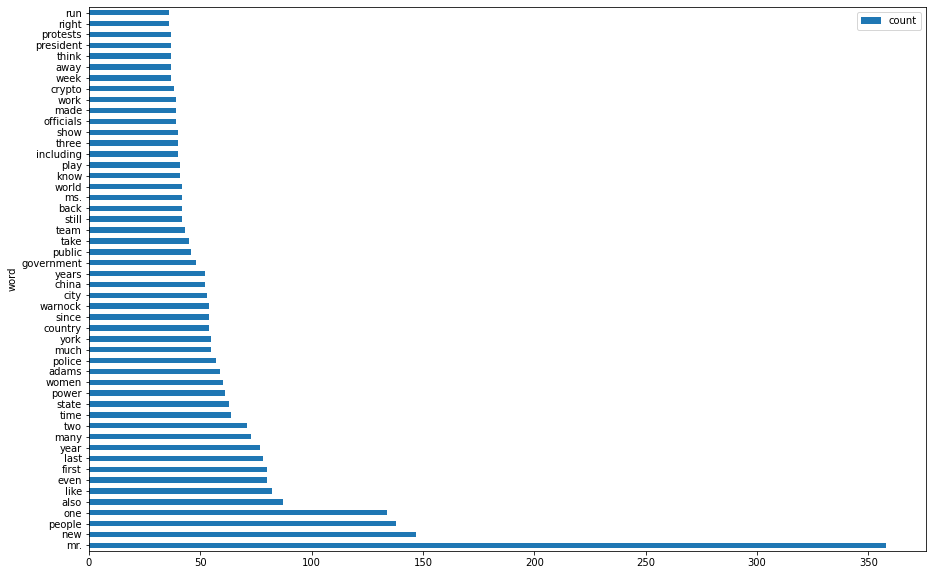

In [ ]:
# let's look at the top 50 words by frequency
count_df[:50].plot.barh(x='word',y='count', figsize=(15,10))

## Reviewing what we learned
* The difference between dynamic and static websites
* How to install `Selenium` in Colab
* How to make a `get` request in `Selenium`
* Navigating markup (HTML) in `Selenium`
* Using `Selenium` and `BeautifulSoup` together to extract text
* Pulling text and populating a `DataFrame`
* Plotting word frequency, excluding stopwards and punctuation

As a challenge, try scraping the New York Times archive. In `Selenium`, though we didn't cover it here, you can input queries into search bars and navigate through dynamically generated results. Read more about it [here](https://selenium-python.readthedocs.io/navigating.html#interacting-with-the-page).

Once you have a `DataFrame`, try doing what we did above and calculate word frequency, but not for a given day's articles, but rather for a particular search. You could even package all of it into a single function whose only input is a search string. That way, we could visualize the most important subtopics for any given topic in the history of the Times. If you give that a try and get confused or want to show off what you did, feel free to reach out to me at peter.nadel@tufts.edu

# Thanks for reading